# pandapowerFMU: simple example

This section shows an example on how to run a consecutive powerflow simulation using pandapower in a FMU.
The following steps are needed and discussed in the following:
1. create `pandapower` network as usual
2. modify it by adding additional attributes (`profiles`, `result_file`, `fmi_input_vars`, `fmi_output_vars`, `time_step`)
3. save the network to a file using `pickle`
4. create an FMU using `createFMU` from `fmipp`
5. run simulations using the FMU
6. read and analyze results

## install required packages

The following packages are required:
- `pandas` (https://pandas.pydata.org/) <br>
- `pandapower` (https://pandapower.readthedocs.io/) <br>
- `fmipp` (https://pypi.org/project/fmipp/) <br> 

Note that FMI++ should be installed from the PyPI as pre-compiled binary package (Python wheel):
```powershell
$ pip install fmipp --prefer-binary
```

## create pandapower network

We use pandapower's [simple example network](https://pandapower.readthedocs.io/en/v1.5.1/networks/example.html#simple-example-network) and load it from pandapower's `networks` module. However, any other network (also custom built ones) could be used instead.

In [1]:
import pandapower.networks as pn
net = pn.example_simple()

Be aware that the transformator parameters of '25 MVA 110/20 kV' has changed. The old parameter values are available in '25 MVA 110/20 kV v1.4.3 and older' on an interim basis.


## add network attributes

This is the most important step since we add information to make network parameters time dependent, on which input and output variables the FMU should have, where to store the results and when to run additional power flows. Note that all these attributes are optional.

### `profiles`

The profiles attribute must be a `pandas.DataFrame` and needs to be added to the pandapower network object to make certain parameters time-dependent. The dataframe must have the following columns:
- class (`string`): must be the name of a pandas dataframe in the pandapower network, e.g., 'load' or 'sgen'; also results dataframes can be used, e.g., 'res_load'
- component (`string`): this is the name of the component, e.g., 'static generator 1'; be aware that this name must be unique within each class
- parameter (`string`): the name of the parameter of the component that is time-dependent, e.g., 'p_kw' or 'q_kvar'
- profile (`pandas.Series`): the time series profile where `index` and `value` pairs represent time and parameter value, respectively
- file (`string`): the path to the file from which the profile should be loaded (file should not have headers and columns need to be seperated by commas); the first column in the file must be time (`float`); be aware that relative paths must be relative to the FMU's `resources` folder should therefore be added to the FMU using the `optional_files` when FMU is created
- column (`int`): the column number in the file from which the profile should be loaded (`0` must be the time index); the values of the series should of course have the same `type` as the pandapower network parameter to which it is connected

Note that when the profile is directly given in the profile column it will not be loaded from file again.

In [2]:
import pandas as pd
# create an empty dataframe with all necessary columns
profiles = pd.DataFrame(columns=['class', 'component', 'parameter', 'file', 'column', 'profile'])
# for the active and reactive power 'p_kw' and 'q_kvar' of 'static generator' with class 'sgen' the columns '1' and '2' from file 'pvgen.csv' should be used
profiles.loc[0] = ['sgen', 'static generator', 'p_kw',  r'pvgen.csv', '1', None] 
profiles.loc[1] = ['sgen', 'static generator', 'q_kvar',  r'pvgen.csv', '2', None] 
# for the active and reactive power 'p_kw' and 'q_kvar' of 'load' with class 'load' we want to attach the series directly in the dataframe
series_pkw = pd.read_csv('elload.csv', header=None, index_col=0, usecols=[0, 1])[1] # we load the series for active power from file ...
profiles.loc[2] = ['load', 'load', 'p_kw', None, None, series_pkw] # ...and attach it as profile
series_qkvar = pd.read_csv('elload.csv', header=None, index_col=0, usecols=[0, 2])[2] # we load the series for reactive power from file ...
profiles.loc[3] = ['load', 'load', 'q_kvar', None, None, series_qkvar] # ...and attach it as profile
# we pass the dataframe to the pandapower network
net.profiles = profiles
net.profiles

,class,component,parameter,file,column,profile
0,sgen,static generator,p_kw,pvgen.csv,1,None
1,sgen,static generator,q_kvar,pvgen.csv,2,None
2,load,load,p_kw,None,None,0 0.0 14.101415 900.0 15.678...
3,load,load,q_kvar,None,None,0 0.0 4.634911 900.0 5.15326...


### `result_file`

The result_file attribute must be of type `string`. This is the path where the result file should be created. After each time step a result row is attached to this file containing all result dataframes from the pandapower network.

In [3]:
import os
net.result_file = os.path.join(os.getcwd(), 'pandapower_results.csv')
net.result_file

'C:\\Software\\pandapowerFMU\\pandapower_results.csv'

### `fmi_input_vars`

The fmi_input_vars attribute must be of type `dict`. The dictonary keys must be one or more from `'Real'`, `'Integer'`, `'Boolean'` or `'String'` defining the type of input that is passed to the FMU. The input names must then be passed as `list` or `str`. The input names must thereby follow the following nameing convention `class.component.parameter`.

In [4]:
fmi_input_vars = {}
# active power generation 'p_kw' of 'generator' with class 'gen' is defined as input to the FMU
fmi_input_vars['Real'] = ['gen.generator.p_kw'] 
# set network attribute
net.fmi_input_vars = fmi_input_vars

### `fmi_output_vars`

The fmi_output_vars attribute must be of type `dict`. The dictonary keys must be one or more from `'Real'`, `'Integer'`, `'Boolean'` or `'String'` defining the type of input that is passed to the FMU. The input names must then be passed as `list` or `str`. The input names must thereby follow the following nameing convention `class.component.parameter`.

In [5]:
fmi_output_vars = {}
# active and reactive power generation 'p_kw' and 'q_kvar' of 'static generator' with class 'sgen' is defined as output of the FMU
fmi_output_vars['Real'] = ['sgen.static generator.p_kw', 'sgen.static generator.q_kvar']
# set network attribute
net.fmi_output_vars = fmi_output_vars

### `time_step`

The `time_step` attribute must be of type `float`. It specifies the internal time step of the time series simulation. This means that at all times that are a multiple of `time_step` a power flow is done even if the FMU is not called at these times. This allows to update the FMU input parameters less frequently than, e.g., time series values.

In [6]:
net.time_step = 1000.0

## save network object

To store the network object including all its attributes we use `pickle` as provided by pandapower. The file must end with `.p` in compliance with pandapower and to be found in the FMU later on.

In [7]:
import pandapower as pp
# path where to store file
pandapower_net_file = os.path.join(os.getcwd(), 'test.p') 
# files with ending of '.p' are searched in FMU and first one found is loaded by FMU and used as pandapower network
pp.to_pickle(net, pandapower_net_file)

## create FMU

Now we are ready to create an FMU using the saved pandapower network. Therefore, we must define the name of the FMU and specify all files that need to be stored within the FMU.

In [8]:
from pandapowerFMU import PandapowerFMUClass
from fmipp.export.createFMU import createFMU
# define FMU model name
model_name = 'pandapowertest'
# specify all optional files; the stored pandapower network must be included together with all files that are referenced using a relative path.
optional_files = [pandapower_net_file, 'pvgen.csv'] # we pass the stored network together with the file that contains the time series for 'static generator'
# executing this function creates the FMU in the current working directory
createFMU( PandapowerFMUClass, model_name, fmi_version = '2', verbose = True, optional_files = optional_files)

[DEBUG] Using FMI version 2
[DEBUG] FMI model identifier: pandapowertest
[DEBUG] Aditional files:
	C:\Software\pandapowerFMU\test.p
	pvgen.csv
[DEBUG] Class 'PandapowerFMUClass' defined in file: C:\Software\pandapowerFMU\pandapowerFMU\PandapowerFMUClass.py


Be aware that the transformator parameters of '25 MVA 110/20 kV' has changed. The old parameter values are available in '25 MVA 110/20 kV v1.4.3 and older' on an interim basis.


[DEBUG] FMI input variables:
	gen.generator.p_kw (Real)
[DEBUG] FMI output variables:
	sgen.static generator.p_kw (Real)
	sgen.static generator.q_kvar (Real)
[DEBUG] FMI parameters:
[DEBUG] Added additional file to model description:  test.p
[DEBUG] Added additional file to model description:  pvgen.csv
[DEBUG] Created script for running the backend implementation:  run_backend_7360a5e6-ab81-11e8-85bf-1c4d704d35f9.py
[DEBUG] FMU created successfully: pandapowertest.fmu


## run simulation

To run a simulation using the created FMU we use the [FMI++ package](https://pypi.org/project/fmipp/). First the FMU must be extracted.

In [9]:
import fmipp
# path to the FMU
fmufile = os.path.join(os.getcwd(), model_name + '.fmu')
# extract FMU in current working directory
path_to_extracted_fmu = os.getcwd()
uri_to_extracted_fmu = fmipp.extractFMU( fmufile, path_to_extracted_fmu) 
# we set logging on
logging_on = True
# create the fmu object
fmu = fmipp.FMUCoSimulationV2( uri_to_extracted_fmu, model_name, logging_on )

Now we instantiate and initialize the FMU. Thus, we need to set the start and end time of the simulation. 

In [10]:
# set start time and end time
t_start = 0.0
t_end = 24 * 60 * 60
# instantiate the FMU
visible = True
interactive = False
status = fmu.instantiate( model_name, t_start, visible, interactive ) 
assert status == fmipp.fmiOK 
# initialize the FMU
status = fmu.initialize(t_start, True, t_end)
assert status == fmipp.fmiOK

We run the simulation for the first half of the time period using a fixed step size `t_step_const` and set the active power of 'generator' to 1000 kW.

In [11]:
import numpy as np
t_sym = t_start
t_step_const = 900.
while t_sym - (t_start+(t_end-t_start)/2) < 1e-4:
    # set active power 'p_kw' of 'generator' to 1000 kW
    fmu.setRealValue('gen.generator.p_kw', 1000)
    # Make co-simulation step.
    new_step = True
    status = fmu.doStep( t_sym, t_step_const, new_step )
    assert status == fmipp.fmiOK
    t_sym += t_step_const

 For the second half of the simulation we use a varying step size (uniformly distributed between 100 and 2000) and we linearly decrease the active power of 'generator' in order to reach 0 kW at the end of the simulation.

In [12]:
while t_sym - t_end < 1e-4:  
    # set active power 'p_kw' of 'generator' to 1/2*(t_end-t_start)*1000 kW
    power = 1000. * 2 * (1-t_sym/t_end)
    fmu.setRealValue('gen.generator.p_kw', power)
    # Make co-simulation step.
    t_step = np.random.uniform(low=100.0, high=2000.0)
    new_step = True
    status = fmu.doStep( t_sym, t_step, new_step )
    assert status == fmipp.fmiOK
    t_sym += t_step

# read results

Now we are ready to load and analyze the result file generated by the FMU. The best solution is to load it into a `pandas.DataFrame` using the first three rows as column index. The first level of the multi-index column corresponds to the `class` the second to the `component` and the third to the `parameter` and thus following the `class.component.parameter` convention.

In [13]:
# read result files
df_res = pd.read_csv(net.result_file, header=[0,1,2], index_col=0)

Let's take a look at the parameters that were directly controlled using FMI inputs, i.e., `'gen.generator.p_kw'`.

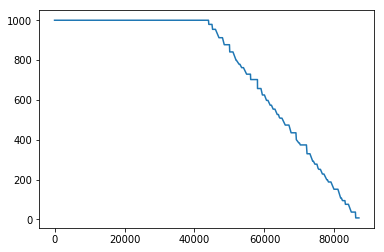

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the relevant parameter
df_res['gen']['generator']['p_kw'].plot()
plt.show()

We see that the inputs given at the different time steps were set accordingly. The input value stays constant for all power flows that are than internally as a result of setting `time_step`.

Let us now compare the results for the time-series parameters that were passed through input files, i.e., `'sgen.static generator.p_kw'` and `'sgen.static generator.q_kvar'` with their original data in the files.

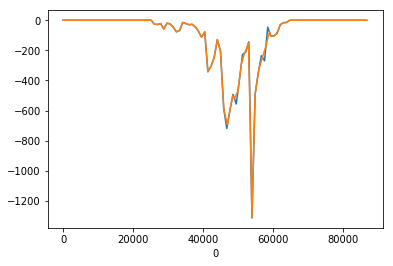

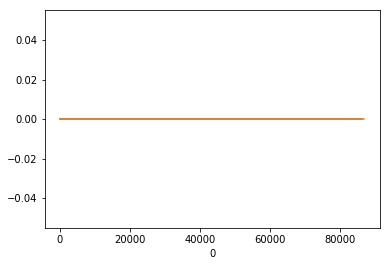

In [15]:
# plot the relevant parameter
pd.read_csv('pvgen.csv', header=None, index_col=0, usecols=[0, 1])[1][t_start:t_end].plot() # load time series from file
df_res['sgen']['static generator']['p_kw'].plot()
plt.show()
pd.read_csv('pvgen.csv', header=None, index_col=0, usecols=[0, 2])[2][t_start:t_end].plot() # load time series from file
df_res['sgen']['static generator']['q_kvar'].plot()
plt.show()

We see differences in the active power paramter for the second half of the simulation. These differences are a result of the variable time step that was applied there. At times that were not included in the data file one-to-one, e.g., `t_sym = 40175.2` a linear interpolation was applied.

Then, we compare the parameters that were passed directly as `pandas.Series` to the `profiles` dataframe, i.e., `'load.load.p_kw'` and `'load.load.q_kvar'`. However, here we need to take the scaling parameter into account that was set for this load, i.e., `net.load.iloc[0]['scaling']`

In [16]:
net.load.iloc[0]['scaling']

0.6

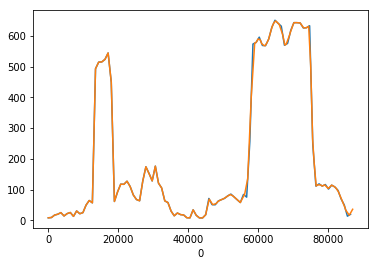

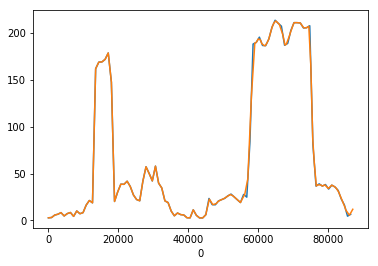

In [17]:
# plot the relevant parameter
(pd.read_csv('elload.csv', header=None, index_col=0, usecols=[0, 1])[1][t_start:t_end]*net.load.iloc[0]['scaling']).plot() # load time series from file
df_res['load']['load']['p_kw'].plot()
plt.show()
(pd.read_csv('elload.csv', header=None, index_col=0, usecols=[0, 2])[2][t_start:t_end]*net.load.iloc[0]['scaling']).plot() # load time series from file
df_res['load']['load']['q_kvar'].plot()
plt.show()

Again we see that the series correspond perfectly for the first half of the simulation where a constant time step that corresponds with the time step of the data. For the second half we see differences as a result of the variable time step. 

And finally we check if results are included for all multiples of `time_step`.

In [18]:
all([t in df_res.index for t in np.arange(t_start, t_end, net.time_step)])

True